## Environment

In [1]:
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from environment import RoadEnvironment
from environment_presets import small_environment_dict, smallest_environment_dict

### Define the environment

In [2]:
# env = RoadEnvironment(**small_environment_dict)

env = RoadEnvironment(**smallest_environment_dict)

Baseline: Do-nothing action

In [3]:
NUM_EPISODES = 1_000

store_do_nothing_rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    env.reset()
    # do-nothing actions
    actions = [[0]*segments for segments in env.edge_segments_numbers]
    done = False

    total_reward = 0

    while not done:

        _, reward, done, info = env.step(actions)

        total_reward += reward

    store_do_nothing_rewards[episode] = total_reward

print(f'Mean reward over {NUM_EPISODES} episodes: {np.mean(store_do_nothing_rewards)}')

Mean reward over 1000 episodes: -89.55


### Define joint state and action space

In [4]:
num_components = sum(env.edge_segments_numbers)
time_horizon = env.max_timesteps

component_actions = [0, 2, 3]
num_component_actions = len(component_actions)

num_damage_states = 4

# cartesian product of damage states
_joint = itertools.product(range(num_damage_states), repeat=num_components)

# cartesian product of _joint and time horizon
joint_state_space = list(itertools.product(range(time_horizon), _joint, repeat=1))

# cartesian product of actions
joint_action_space = list(itertools.product(component_actions, repeat=num_components))

# compute size of joint state and action spaces
num_joint_states = num_damage_states**num_components * time_horizon
num_joint_actions = num_component_actions**num_components

print(f"num_components: {num_components}")
print(f"num_joint_states: {num_joint_states}")
print(f"num_joint_actions: {num_joint_actions}")

num_components: 2
num_joint_states: 320
num_joint_actions: 9


Helper functions

In [5]:
def encode_state(timestep, state):
    _state = (timestep, tuple([item for sub_list in state for item in sub_list]))
    return joint_state_space.index(_state)

def decode_state(state_idx):
    return joint_state_space[state_idx]

def encode_action(action):
    return joint_action_space.index(action)

def decode_action(action_idx):
    action = joint_action_space[action_idx]
    return [[a] for a in action]

## Q Learning

Setup

In [6]:
DISCOUNT_FACTOR = 1

# randomly initialize Q-values
Q_values = np.ones((num_joint_states, num_joint_actions))

# conditions for convergence
learning_rate_start = 0.9
learning_rate_end = 0.3

epsilon_start = 1
epsilon_end = 0.3

epsilon = epsilon_start
learning_rate = learning_rate_start

NUM_EPISODES = 500_000

# sample state_idxs from joint state space to plot coverage of Q-values
num_samples = 10
sample_state_idxs = np.random.choice(range(num_joint_states), num_samples)

logging_freq = 100

logger = { "episode": [], 
           "cost": [],
           "store_q_values": np.zeros((NUM_EPISODES // logging_freq, 10))}

Training

In [7]:
for episode in range(NUM_EPISODES):

    _ = env.reset()
    done = False
    timestep = 0

    state_idx = encode_state(timestep, env._get_states())
    total_reward = 0

    while not done:

        # ε-greedy policy to select actions
        # select random action with probability ε
        # |---------------ε----|
        # 0                    1
        if random.uniform(0, 1) < epsilon:
            action_idx = np.random.randint(0, num_joint_actions)
        # select greedy action
        # simply act greedily wrt Q values
        else:
            # get Q values of all actions in current state
            q_values = Q_values[state_idx, :]
            # if more than one action provides maximum, 
            # we break ties randomly
            greedy_action_idxs = np.flatnonzero(q_values == max(q_values))
            action_idx = np.random.choice(greedy_action_idxs)

        # convert action index to action
        action = decode_action(action_idx)

        # take action and observe next state and reward
        _, reward, done, info = env.step(action)
        timestep += 1

        total_reward += reward

        # get index of next state
        if not done:
            next_state_idx = encode_state(timestep, info["states"])

        ####### Q-learning update #######

        # get current Q values
        old_q = Q_values[state_idx, action_idx]

        # compute value of next_state
        # V(s') = max_a' Q(s', a')
        if done:
            future_value = 0
        else:
            future_value = max(Q_values[next_state_idx, :])

        # TD_target = r + γ max_a' Q(s', a')
        TD_target = reward + DISCOUNT_FACTOR * future_value

        # update Q table
        # Q(s,a) = Q(s, a) + α (TD_target - Q(s,a))
        Q_values[state_idx, action_idx] = old_q + learning_rate * (TD_target - old_q)

        # update state
        state_idx = next_state_idx

    if episode % logging_freq == 0:
        logger["episode"].append(episode)
        for i, idx in enumerate(sample_state_idxs):
            logger["store_q_values"][episode // logging_freq, i] = max(Q_values[idx, :])

    # update epsilon
    epsilon = max(epsilon_end, epsilon_start - episode / NUM_EPISODES)

    # update learning rate
    learning_rate = max(learning_rate_end, learning_rate_start - episode / NUM_EPISODES)

## Visualizations

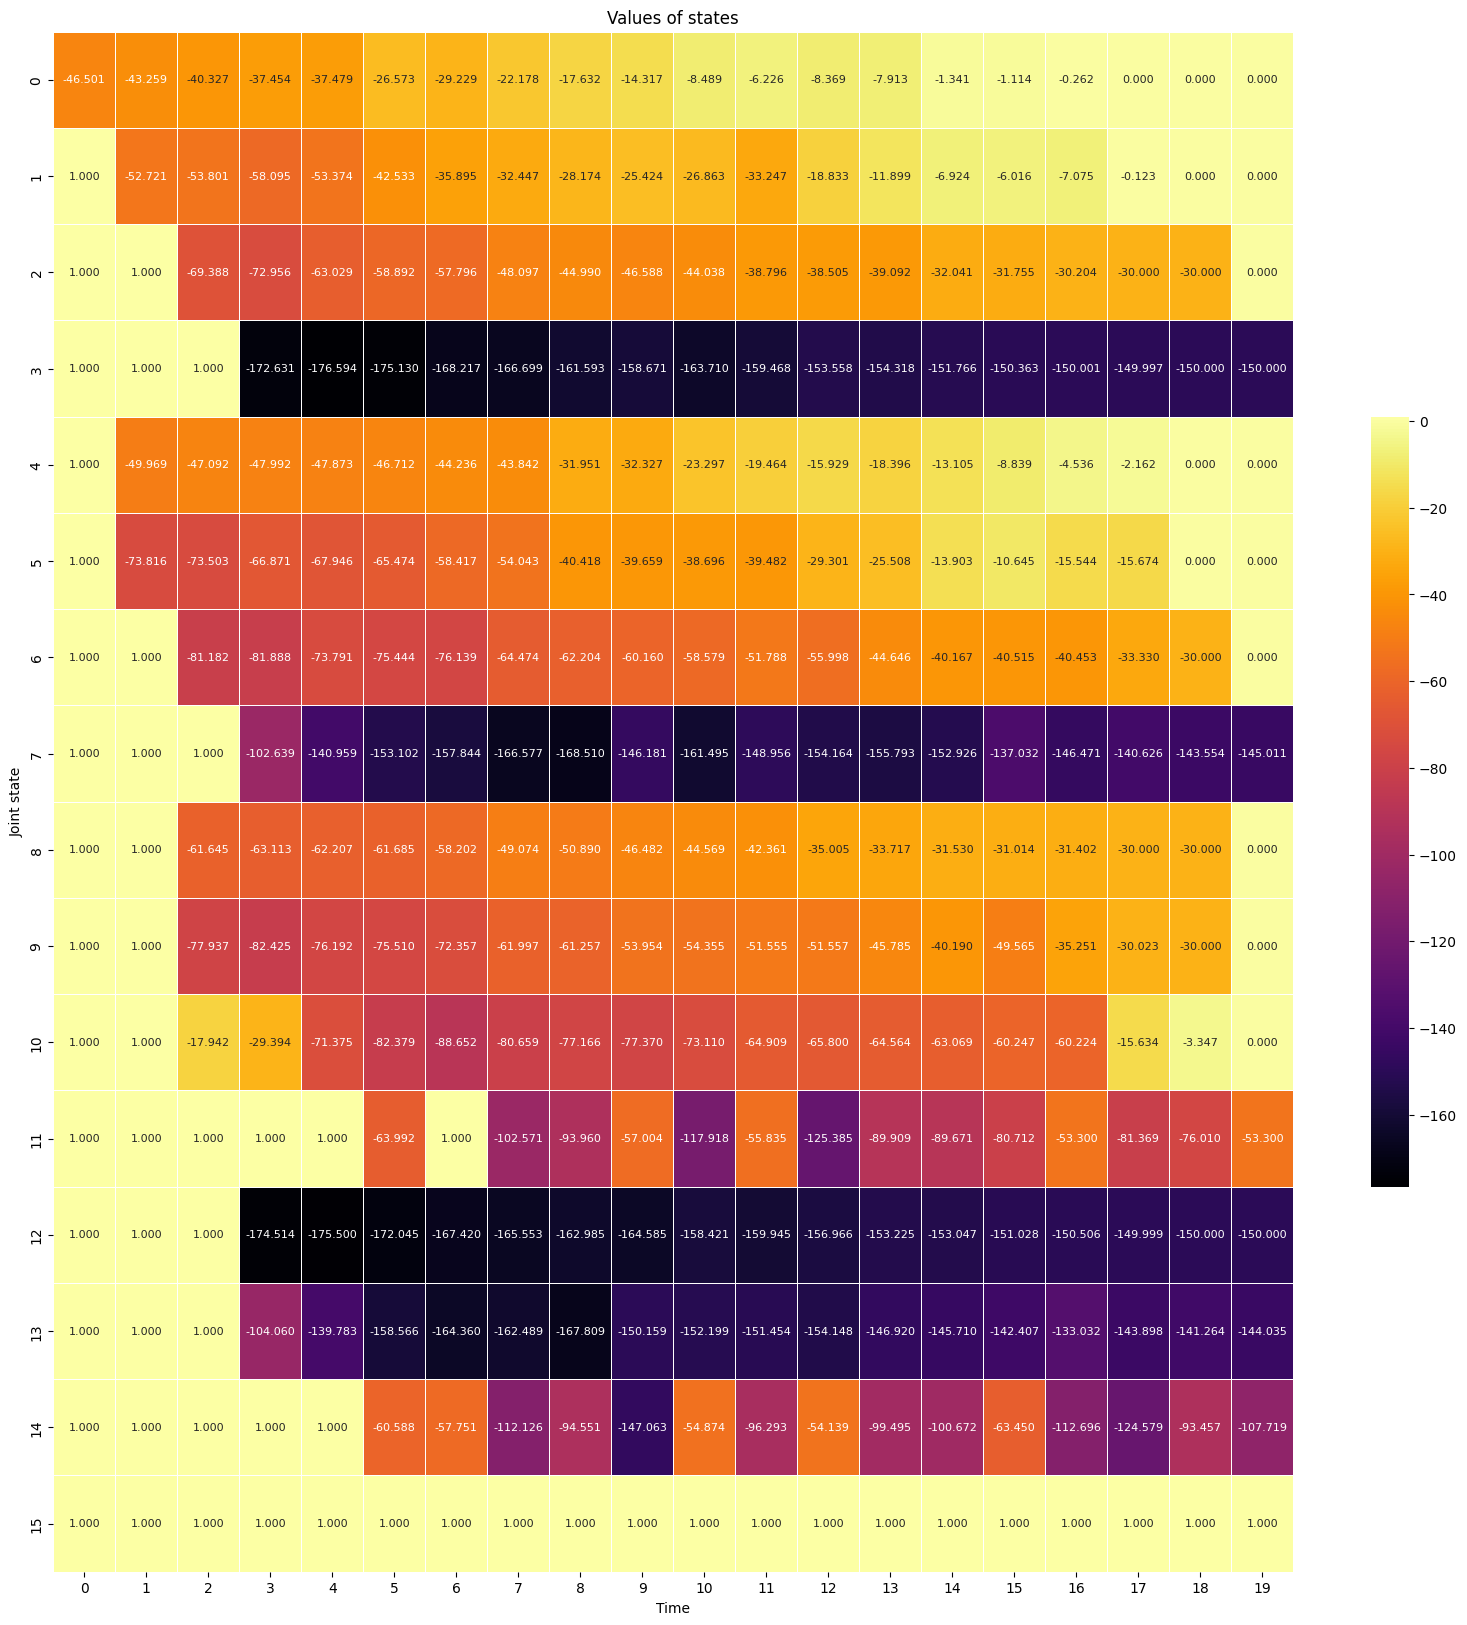

In [8]:
optimal_values = np.max(Q_values, axis=1)
_value_func_2d = optimal_values.reshape(time_horizon, num_damage_states**num_components, order='C')

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(_value_func_2d.T, annot=_value_func_2d.T, fmt='.3f',
            annot_kws={"size": 8}, linewidths=.5, ax=ax,
            cmap="inferno", cbar_kws={"shrink": .5})

ax.set_xlabel('Time')
ax.set_ylabel('Joint state')
ax.set_title('Values of states')

plt.show()

### Convergence plot

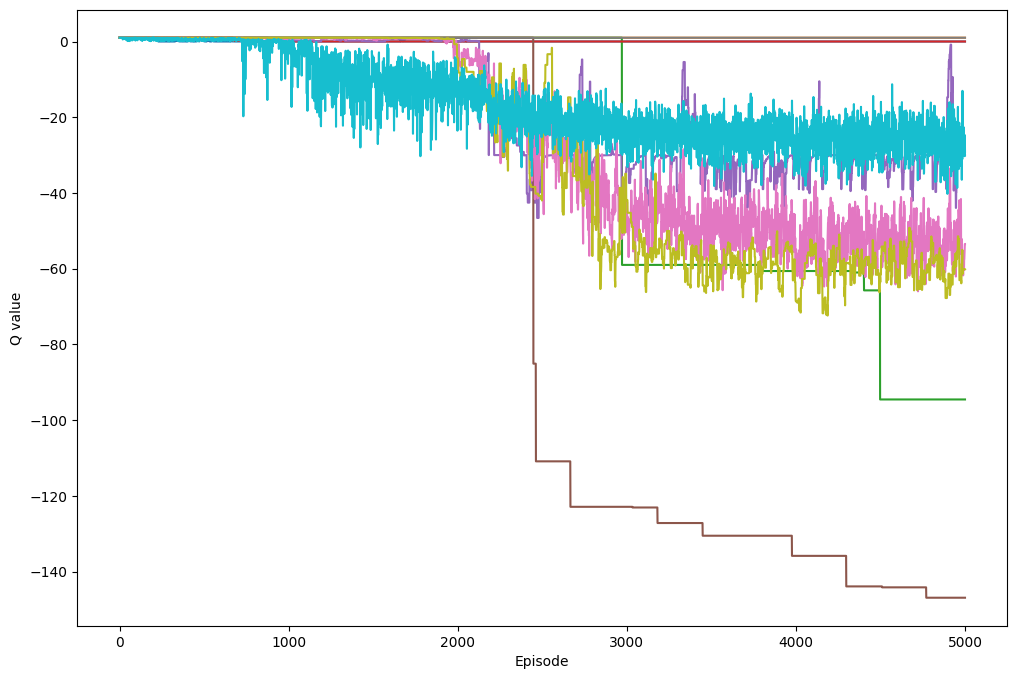

In [9]:
# plot q values from logger
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(sample_state_idxs)):
    ax.plot(logger["store_q_values"][:, i], '-')

ax.set_xlabel("Episode")
ax.set_ylabel("Q value")

plt.show()

## Inference with optimal policy

In [10]:
num_inference = 1_000
store_rewards = np.zeros(num_inference)

for ep in range(num_inference):

    _ = env.reset()
    done = False
    timestep = 0

    state_idx = encode_state(timestep, env._get_states())
    
    total_reward = 0

    while not done:

        # get Q values of all actions in current state
        q_values = Q_values[state_idx, :]
        # if more than one action provides maximum, 
        # we break ties randomly
        greedy_action_idxs = np.flatnonzero(q_values == max(q_values))
        action_idx = np.random.choice(greedy_action_idxs)

        # convert action index to action
        action = decode_action(action_idx)

        # take action and observe next state and reward
        _, reward, done, info = env.step(action)
        timestep += 1
        
        total_reward += reward

        # get index of next state
        if not done:
            state_idx = encode_state(timestep, info["states"])

    store_rewards[ep] = total_reward

In [11]:
print("Inference with 1000 episodes")

print(f"Optimal policy | µ={np.mean(store_rewards):.3f}")

print(f"Do-nothing policy | µ={np.mean(store_do_nothing_rewards):.3f}")

Inference with 1000 episodes
Optimal policy | µ=-49.775
Do-nothing policy | µ=-89.550


## Optimal Policy

In [12]:
optimal_policy = {}

for state_idx in range(num_joint_states):

    q_values = Q_values[state_idx, :]

    state = decode_state(state_idx)

    greedy_action_idxs = np.flatnonzero(q_values == max(q_values))

    _opt = []
    for action_idx in greedy_action_idxs:
        # convert action index to action
        action = joint_action_space[action_idx]
        _opt.append(action)

    optimal_policy[state] = _opt

Print optimal policy

In [14]:
print("State ID: State | Optimal action(s) \n")

for i, (state, actions) in enumerate(optimal_policy.items()):
    print(f"{i}: {state} | {actions} \n")

State ID: State | Optimal action(s) 

0: (0, (0, 0)) | [(0, 0)] 

1: (0, (0, 1)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

2: (0, (0, 2)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

3: (0, (0, 3)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

4: (0, (1, 0)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

5: (0, (1, 1)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

6: (0, (1, 2)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

7: (0, (1, 3)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

8: (0, (2, 0)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

9: (0, (2, 1)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

10: (0, (2, 2)) | [(0, 0), (0, 2), (0, 3), (2, 0), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3)] 

11: (0, (2, 3